## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import time
import os
import copy
import pandas as pd

import matplotlib.pyplot as plt

import cv2

import skimage.io 
import csv
import os

from joblib import Parallel, delayed
import multiprocessing
from math import sqrt
import pandas as pd

from tensorflow.keras.models import save_model, load_model

from skimage.measure import shannon_entropy
from skimage.metrics import structural_similarity as compare_ssim
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm


2024-04-25 01:52:36.894854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Functions

In [2]:
#Load the images and the segmentation
def getImagesAndSegmentations(path):
    folder_path = path
    # Get a list of all files in the folder
    file_names = os.listdir(folder_path)
    file_names.sort()
    # Load all images from the folder
    # Arrays to store images and segmentations
    image_array = []
    segmentation_array = []
    
    # Load images and segmentations
    for i in range(len(file_names)):
        file_name = file_names[i]
        
        # Check if the file is a segmentation
        if file_name.endswith('_seg.jpg') or file_name.endswith('_seg.png'):
            # Load the segmentation
            seg = skimage.io.imread(os.path.join(folder_path, file_name))
            segmentation_array[-1] = [file_name,seg]
        else:
            # Load the image
            img = skimage.io.imread(os.path.join(folder_path, file_name))
            image_array.append([file_name, img])
            # If segmentation doesn't exist, store -1
            segmentation_array.append(-1)
            
    return image_array, segmentation_array

def otsuSegmentation(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Assuming arr is your NumPy array
    arr = np.array(segmented_image)
    
    # Replace 255 with 0 and 0 with 1
    segmented_image = np.where(arr == 255, 0, 1)
    
    return np.array(segmented_image).astype('uint8')

def dice_coef(seg1, seg2, orig):
        if seg1.shape != seg2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:
            result = cv2.bitwise_and(orig, orig, mask=seg1)
            result2 = cv2.bitwise_and(orig, orig, mask=seg2)

            lenIntersection=0
            
            for i in range(result.shape[0]):
                for j in range(result.shape[1]):
                    if ( np.array_equal(result[i][j],result2[i][j]) ):
                        lenIntersection+=1
             
            lenimg=result.shape[0]*result.shape[1]
            lenimg2=result2.shape[0]*result2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value

def resizeImages(images):
    # Define a common size for resizing the images
    target_size = (500, 300)  # Adjust this size as needed
    
    # Convert image data to numpy array and resize
    resized_images = []
    for image in tqdm(images):
        # Resize the image
        resized_img = cv2.resize(image, target_size)
        # Append to resized_images list
        resized_images.append(resized_img)
    return resized_images

def calculate_asymmetry(image):
    # Mirror the left half of the image
    mirrored = np.fliplr(image[:, :image.shape[1] // 2, :])
    # Compute structural similarity index (SSIM)
    # Ensure the window size does not exceed the smaller side of the image
    window_size = 3  # You can adjust this window size as needed (e.g., 3x3 or 5x5)
    ssim = compare_ssim(image[:, image.shape[1] // 2:, :], mirrored, multichannel=True, win_size=window_size)
    return ssim

def calculate_border_irregularity(image,i):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute the perimeter of the largest contour
    perimeter = cv2.arcLength(contours[0], True)
    # Compute the area of the largest contour
    area = cv2.contourArea(contours[0])
    
    if area == 0:
        # Plot the image with contours
        print('position ' + str(i))
        plt.imshow(image)
        plt.title("Image with Contours (Area = 0)")
        plt.axis('off')
        for contour in contours:
            plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='red', linewidth=2)
        plt.show()
    
    # Calculate compactness (perimeter^2 / area)
    compactness = (perimeter ** 2) / area
    return compactness

def calculate_color_features(image):
    # Convert image to Lab color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # Split channels
    l, a, b = cv2.split(lab)
    # Calculate mean and standard deviation of each channel
    l_mean, l_std = np.mean(l), np.std(l)
    a_mean, a_std = np.mean(a), np.std(a)
    b_mean, b_std = np.mean(b), np.std(b)
    return l_mean, l_std, a_mean, a_std, b_mean, b_std

def calculate_dimension(image):
    # Compute area of the lesion
    area = np.sum(image > 0)
    # Compute bounding box of the lesion
    _, _, width, height = cv2.boundingRect(image)
    # Compute aspect ratio
    aspect_ratio = width / height
    return area, aspect_ratio

def calculateABCD(image):
    asymmetry_score = calculate_asymmetry(image)
    l_mean, l_std, a_mean, a_std, b_mean, b_std = calculate_color_features(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    area, aspect_ratio = calculate_dimension(gray_image)
    return [asymmetry_score, l_mean, l_std, a_mean, a_std, b_mean, b_std, area, aspect_ratio]

def calculateABCD_parallel(images):
    num_cores = multiprocessing.cpu_count()
    ABCD = Parallel(n_jobs=num_cores)(delayed(calculateABCD)(image) for image in images)
    return ABCD

## Load data

### Images

In [3]:
# Path to the folder containing the images
train_folder_path = '../data/Train/Train/'
train_images, train_seg = getImagesAndSegmentations(train_folder_path)
test_folder_path = '../data/Test/Test/'
test_images, test_seg = getImagesAndSegmentations(test_folder_path)

### Metadata

In [4]:
# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTest = pd.read_csv('../data/metadataTest.csv')
metaDataTest = metaDataTest.sort_values('ID')

# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTrain = pd.read_csv('../data/metadataTrain.csv')
metaDataTrain = metaDataTrain.sort_values('ID').reset_index(drop=True)
#first_row = metaDataTrain.iloc[index_of_a]  # Extract the first row using iloc
#print(first_row[0])
train_SEX = metaDataTrain['SEX'].values
train_AGE = metaDataTrain['AGE'].values
train_POSITION = metaDataTrain['POSITION'].values

test_SEX = metaDataTest['SEX'].values
test_AGE = metaDataTest['AGE'].values
test_POSITION = metaDataTest['POSITION'].values

## Segmentate and Calculate Dice Score

### Training

In [5]:
#this function will both calculate the segmentations and store them in segmented_images
#and at the end calculate the dice score
segmented_images = []

def calculateAverageDice():
    # Initialize variables for calculating the average Dice score
    total_dice_score = 0
    num_segmented_images = 0
    
    # Loop through train_seg to calculate Dice score for images with segmentations
    for i in range(len(train_seg)):
        # Check if segmentation mask exists
        if train_seg[i] != -1:
            # Perform Otsu's segmentation on the corresponding image
            segmented_image = otsuSegmentation(train_images[i][1])
            segmented_images.append(cv2.bitwise_and(train_images[i][1], train_images[i][1], mask=train_seg[i][1]))
            # Calculate Dice score
            dice_score = dice_coef(train_seg[i][1], segmented_image, train_images[i][1])
            # Accumulate the total score
            total_dice_score += dice_score
            # Increment the count of segmented images
            num_segmented_images += 1
        else:
            segmented_image = otsuSegmentation(train_images[i][1])
            segmented_images.append(cv2.bitwise_and(train_images[i][1], train_images[i][1], mask=segmented_image))
    
    # Calculate the average Dice score
    if num_segmented_images > 0:
        average_dice_score = total_dice_score / num_segmented_images
    else:
        average_dice_score = 0
    return average_dice_score


average_dice_score = calculateAverageDice()
#average_dice_score = joblib_segmentation()
print("Average Dice Score:", average_dice_score)

Average Dice Score: 0.846433494882943


### Test

In [6]:
#this function will both calculate the segmentations and store them in segmented_images
#and at the end calculate the dice score
segmented_test_images = []

def calculateAverageDiceTest():
    # Initialize variables for calculating the average Dice score
    total_dice_score = 0
    num_segmented_images = 0
    
    # Loop through test_seg to calculate Dice score for images with segmentations
    for i in range(len(test_seg)):
        # Check if segmentation mask exists
        if test_seg[i] != -1:
            # Perform Otsu's segmentation on the corresponding image
            segmented_image = otsuSegmentation(test_images[i][1])
            segmented_test_images.append(cv2.bitwise_and(test_images[i][1], test_images[i][1], mask=test_seg[i][1]))
            # Calculate Dice score
            dice_score = dice_coef(test_seg[i][1], segmented_image, test_images[i][1])
            # Accumulate the total score
            total_dice_score += dice_score
            # Increment the count of segmented images
            num_segmented_images += 1
        else:
            segmented_image = otsuSegmentation(test_images[i][1])
            segmented_test_images.append(cv2.bitwise_and(test_images[i][1], test_images[i][1], mask=segmented_image))
    
    # Calculate the average Dice score
    if num_segmented_images > 0:
        average_dice_score = total_dice_score / num_segmented_images
    else:
        average_dice_score = 0
    return average_dice_score


average_dice_testscore = calculateAverageDiceTest()
print(average_dice_testscore)

0.8492443837935374


## Calculate ABCD Features

### Training

In [7]:
segmented_images = resizeImages(segmented_images)
abcd_train = calculateABCD_parallel(segmented_images)
# Save the calculated features in a file
np.save('featuresabcd.npy', abcd_train)
print('ABCD train features saved')

100%|██████████| 18998/18998 [00:17<00:00, 1062.45it/s]


ABCD train features saved


### Test

In [8]:
segmented_test_images = resizeImages(segmented_test_images)
abcd_test = calculateABCD_parallel(segmented_test_images)
np.save('featurestestabcd.npy', abcd_test)
print('ABCD test features saved')

100%|██████████| 6333/6333 [00:03<00:00, 1999.04it/s]


ABCD test features saved


## CNN ResNet

In [9]:
class CustomDataset(Dataset):
    def __init__(self, paths, labels, folder : str, transform):
        """
            paths : list of paths to the images
            labels : list of the labels (between 1 and 8)
            folder : folder containing the data
            transform : the transformation to apply
        """
        self.paths = paths
        self.labels = labels  
        self.transform = transform
        self.folder = folder
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # choose the file
        file = self.paths[idx]
        label = self.labels[idx]-1 # as the label provided are between 1 and 8 (included)
        # open the file
        inp = Image.open(os.path.join(self.folder,file+".jpg"))
        # Apply transformation
        if self.transform :
            inp = self.transform(inp)
                
        return inp, label

In [10]:
learning_rate = 1e-6
num_epochs = 24
batch_size = 64

num_classes = 8
feature_extract = False 

split = 0.15

In [11]:
df = pd.read_csv('../data/metadataTrain.csv')
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int((1-split)*len(paths))

X_train, y_train, X_val, y_val = paths[:val_size], labels[:val_size], paths[val_size:], labels[val_size:]


img_transform = transforms.Compose([
        transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
        transforms.RandomRotation(90),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize((256,256)),             # resize shortest side to 256 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, '../data/Train/Train/', transform=img_transform)
val_dataset = CustomDataset(X_val, y_val, '../data/Train/Train/', transform=img_transform)


image_datasets = {'train':train_dataset, 'val':val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

### Prueba Cristian

             ID  CLASS     SEX   AGE         POSITION
0  ISIC_0000000      2  female  55.0   anterior torso
1  ISIC_0000001      2  female  30.0   anterior torso
2  ISIC_0000002      1  female  60.0  upper extremity
3  ISIC_0000003      2    male  30.0  upper extremity
4  ISIC_0000004      1    male  80.0  posterior torso
5  ISIC_0000007      2  female  25.0  posterior torso
6  ISIC_0000008      2  female  30.0   anterior torso
7  ISIC_0000009      2  female  30.0   anterior torso
8  ISIC_0000010      2  female  35.0  posterior torso
9  ISIC_0000012      2    male  30.0  posterior torso
[2, 2, 1, 2, 1, 2, 2, 2, 2, 2]


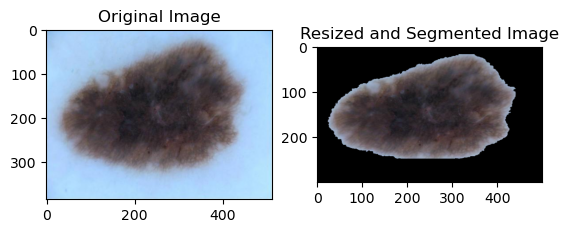

In [71]:
print(metaDataTrain.head(10))
first_column = [row[0] for row in train_images]
index_of_a = first_column.index('ISIC_0000000.jpg')
print(classes_train[:10])
# Plotting the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.imshow(train_images[index_of_a][1], cmap='gray')  # Assuming it's a grayscale image
plt.title('Original Image')

# Plotting the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.imshow(resized_segmented_train_images[0])  # Assuming it's a color image
plt.title('Resized and Segmented Image')

plt.show()

In [61]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images : numpy array of images
        labels : list/array of the labels (between 1 and 8)
        transform : the transformation to apply
        """
        self.images = images
        self.labels = labels  
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        # Convert the numpy array to PIL Image
        image = Image.fromarray(image)
        label = self.labels[idx] - 1  # Adjust label to start from 0
        if self.transform:
            image = self.transform(image)
        return image, label

In [62]:
learning_rate = 1e-6
num_epochs = 24
batch_size = 64

num_classes = 8
feature_extract = False 

split = 0.15

In [63]:
df = pd.read_csv('../data/metadataTrain.csv')
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int((1-split)*len(paths))

X_train, y_train, X_val, y_val = resized_segmented_train_images[:val_size], classes_train[:val_size], resized_segmented_train_images[val_size:], classes_train[val_size:]
#X_train has the name of the images
#y_train has the label of each of them

img_transform = transforms.Compose([
        transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
        transforms.RandomRotation(90),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        #transforms.Resize((300,300)),             # resize shortest side to 256 pixels
        transforms.CenterCrop(350),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


train_dataset = CustomDataset(X_train, y_train, transform=img_transform)
#esta linea de arriba es la que quiero ver y cambiar para utilizar mis imágenes
val_dataset = CustomDataset(X_val, y_val, transform=img_transform)


image_datasets = {'train':train_dataset, 'val':val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

print(torch.cuda.is_available())
print(device)

True
cuda


### Initialize model

In [65]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = models.resnet101(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    
    return model

In [66]:
model = initialize_model(num_classes, feature_extract)

model = model.to(device)

params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

# The parameters are optimizing
#optimizer = optim.Adam(params_to_update, lr=0.001)
#optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

optimizer = optim.Adam(
    [
        {"params": model.fc.parameters(), "lr": learning_rate},
        {"params": model.layer4.parameters(), "lr": learning_rate*10},
        {"params": model.layer3.parameters(), "lr": learning_rate},
        {"params": model.layer2.parameters(), "lr": learning_rate/10},
        {"params": model.layer1.parameters(), "lr": learning_rate/10}
    ],
    lr=learning_rate,
)

# Loss function
#criterion = nn.CrossEntropyLoss()

#to reduce the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# weighted loss
weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))

#loss = torch.nn.CrossEntropyLoss()

/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

### Train model

In [67]:
def train_model(model, dataloaders, optimizer, criterion=loss, num_epochs=num_epochs):
    start = time.time()
    val_acc_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        
        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Do this if model is in training phase
            else:
                model.eval()    # Do this if model is in validation phase
                
            running_loss = 0
            running_corrects = 0
            
            # Iteration over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    
                    # Backward pass and Optimization in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            print('-'*10)
                
    time_elapsed = time.time()
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history

In [68]:
model, history = train_model(model, dataloaders_dict, optimizer, loss, num_epochs)

Epoch 0/23


OutOfMemoryError: CUDA out of memory. Tried to allocate 122.00 MiB. GPU 0 has a total capacity of 39.39 GiB of which 92.19 MiB is free. Process 445875 has 1.25 GiB memory in use. Process 765027 has 7.09 GiB memory in use. Including non-PyTorch memory, this process has 26.74 GiB memory in use. Process 849191 has 4.20 GiB memory in use. Of the allocated memory 25.68 GiB is allocated by PyTorch, and 546.43 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
torch.save(model.state_dict(), 'model.pth')

### Test model

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, paths, folder, transform):
        """
            paths : list of paths to the images
            labels : list of the labels (between 1 and 8)
            
            transform : the transformation to apply
        """
        self.paths = paths
        self.folder = folder
        self.transform = transform
        
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # choose the file
        file = self.paths[idx]
        
        # open the file
        inp = Image.open(os.path.join(self.folder,file+".jpg"))
        # Apply transformation
        if self.transform :
            inp = self.transform(inp)
                
        return inp,file

df_test = pd.read_csv("../data/metadataTest.csv")
paths = list(df_test["ID"])

img_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = CustomTestDataset(paths, '../data/Test/Test', transform=img_transform)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predictions
predictions = []
files = []


# Iterate over the test data
for images, file in test_dataloader:
    # Move the images to the device (e.g., GPU)
    images = images.to(device)
    
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted labels or probabilities
    _, predicted = torch.max(outputs, 1)  # For classification
    predicted = torch.argmax(outputs, dim=1) + 1  # For multi-label classification
     
    # Append the predictions to the list
    files.extend(file)
    predictions.extend(predicted.tolist())

In [ ]:
# Convert predictions to a DataFrame
df_predictions = pd.DataFrame(predictions, columns=['CLASS'])

files = pd.Series(files, name='ID')

df_predictions = pd.concat([files, df_predictions], axis=1)

# Save DataFrame to CSV file
df_predictions.to_csv('prnj1.csv', index=False)

In [ ]:
#Plot the predictions classes
df_predictions['CLASS'].value_counts().plot(kind='bar')
plt.title('Count of images in each class')
plt.show()

## Load Past Data

In [ ]:
# Define the file paths for saving and loading the model
#model_file_path = "model.h5"
# Load the saved model
#loaded_model = load_model(model_file_path)
#print(f"Model loaded from '{model_file_path}'")

#loading train images segmentations
segmented_train_images_file_path = "segmented_images.npy"
segmented_train_images = np.load(segmented_train_images_file_path)
print(f"Segmented train images loaded")
resized_segmented_train_images = resizeImages(segmented_train_images)

#loading test images segmentations
segmented_test_images_file_path = "segmented_test_images.npy"
segmented_test_images = np.load(segmented_test_images_file_path)
print(f"Segmented test images loaded")
resized_segmented_test_images = resizeImages(segmented_test_images)

abcd_train = np.load('featuresabcd.npy')
print('ABCD train features loaded')

abcd_test = np.load('featurestestabcd.npy')
print('ABCD test features loaded')

# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTest = pd.read_csv('../data/metadataTest.csv')
metaDataTest = metaDataTest.sort_values('ID')

# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTrain = pd.read_csv('../data/metadataTrain.csv')
metaDataTrain = metaDataTrain.sort_values('ID').reset_index(drop=True)
classes_train = metaDataTrain.iloc[:, 1].tolist()
print('Metadata loaded')
#first_row = metaDataTrain.iloc[index_of_a]  # Extract the first row using iloc
train_SEX = metaDataTrain['SEX'].values
train_AGE = metaDataTrain['AGE'].values
train_POSITION = metaDataTrain['POSITION'].values

test_SEX = metaDataTest['SEX'].values
test_AGE = metaDataTest['AGE'].values
test_POSITION = metaDataTest['POSITION'].values

Segmented train images loaded


100%|██████████| 18998/18998 [00:04<00:00, 4485.28it/s]


Segmented test images loaded


100%|██████████| 6333/6333 [00:01<00:00, 4505.38it/s]


ABCD train features loaded
ABCD test features loaded
Metadata loaded
